In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp '/content/drive/MyDrive/images.zip' '/content/'
!unzip /content/images.zip -d /content/

In [2]:
import os
import os.path
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import transforms
import math
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.amp import autocast, GradScaler
import torchvision.transforms.functional as TF
# import imgaug.augmenters as iaa

Дата лоадер

In [3]:
def get_pathes(base_folder):
    paths = []
    for i in range(11):
        folder_name = f'{i:02d}'
        image_folder = os.path.join(base_folder, folder_name, 'image_0')
        movements_file = os.path.join(base_folder, folder_name, f'{folder_name}.txt')
        paths.append((image_folder, movements_file))
    return paths

def get_data(batch_size, base_folder = '/content/images'):
    paths = get_pathes(base_folder)

    # Вибір папок для тренування, валідації і тестування
    validation_folder = paths[-2]  # Предостання папка
    test_folder = paths[-1]        # Остання папка
    train_folders = paths[:-2]     # Всі інші папки

    # Читання рухання з файлу
    def create_movements(movements_file):
        movements = []
        with open(movements_file, 'r') as f:
            for line in f:
                data = list(map(float, line.strip().split()))
                movements.append(data)
        return np.array(movements)

    # steps = [1, 2]
    # steps = [1]
    def isRotationMatrix(R):
        Rt = np.transpose(R)
        shouldBeIdentity = np.dot(Rt, R)
        I = np.identity(3, dtype = R.dtype)
        n = np.linalg.norm(I - shouldBeIdentity)
        return n < 1e-6

    def rotationMatrixToEulerAngles(R):
        assert(isRotationMatrix(R))
        sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
        singular = sy < 1e-6

        if  not singular :
            x = math.atan2(R[2,1] , R[2,2])
            y = math.atan2(-R[2,0], sy)
            z = math.atan2(R[1,0], R[0,0])
        else :
            x = math.atan2(-R[1,2], R[1,1])
            y = math.atan2(-R[2,0], sy)
            z = 0

        return np.array([x, y, z])

    def get_relative_pose(pose1, pose2,):
        if len(pose1) == 12:
            pose1 = np.concatenate((pose1.reshape(3, 4), np.array([[0, 0, 0, 1]])), axis=0)
        if len(pose2) == 12:
            pose2 = np.concatenate((pose2.reshape(3, 4), np.array([[0, 0, 0, 1]])), axis=0)

        rel_pose = np.dot(np.linalg.inv(pose1), pose2)

        dx = rel_pose[0, 3]
        dy = rel_pose[1, 3]
        dz = rel_pose[2, 3]

        rel_rot_matrix = rel_pose[:3, :3]
        rx, ry, rz = rotationMatrixToEulerAngles(rel_rot_matrix)

        return dx, dy, dz, rx, ry, rz

    # def find_mean_std(movements):
    #     movements_array = np.array(movements)

    #     mean = np.mean(movements_array, axis=0)
    #     std = np.std(movements_array, axis=0)
    #     return mean,std

    def normalize_movements(movements, mean, std):
        movements_array = np.array(movements)
        normalized_movements = (movements_array - mean) / std
        # normalized_movements = movements_array / std
        normalized_movements = normalized_movements.tolist()
        return normalized_movements
        # return normalized_movements, mean, std


    def transform_mov(movements, steps):
        res_movements = []
        # for i in range(len(movements)-1):
        # matrices = get_relative_pose(movements)
        for i in range(len(movements)):
            for step in steps:
                if i + step < len(movements):
                    m1 = movements[i]
                    m2 = movements[i + step]
                    dx, dy, dz, rx, ry, rz = get_relative_pose(m1, m2)
                    res_movements.append([dx, dy, dz, rx, ry, rz])
        return res_movements
    step = 1
    # класс Dataset
    class ImageDataset(Dataset):
        def __init__(self, image_folder, movements, transform=None ):
            # Отримуємо список всіх файлів .png і сортуємо їх
            all_image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')])
            self.image_files = all_image_files
            self.movements = movements
            self.transform = transform

        def __len__(self):
            return min(len(self.movements), len(self.image_files) - 5)


        def __getitem__(self, idx):
            pathes = self.image_files[idx: idx + 5*step :step]
            images = [Image.open(p).convert('L') for p in pathes]
            if self.transform:
                images = [self.transform(img) for img in images]
            images = torch.stack(images, dim=0)  # [5, 1, H, W]
            movement = self.movements[idx + 4*step].clone().float() if isinstance(self.movements[idx+ 4*step], torch.Tensor) else torch.tensor(self.movements[idx + 4*step], dtype=torch.float32)
            return images, movement

    # step = 1
     # класс Dataset
    # class ImageDataset(Dataset):
    #     def __init__(self, image_folder, movements, transform=None ):
    #         # Отримуємо список всіх файлів .png і сортуємо їх
    #         all_image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')])
    #         self.image_files = all_image_files
    #         self.movements = movements
    #         self.transform = transform

    #     def __len__(self):
    #         # Повертаємо мінімальну довжину між рухами та зображеннями - 1
    #         return min(len(self.movements), len(self.image_files) - 5)


    #     def __getitem__(self, idx):
    #         pathes = self.image_files[idx: idx + 5*step :step]
    #         images = [Image.open(p).convert('L') for p in pathes]


    #         # if self.transform:
    #         #     image1, image2 = self.transform(image1, image2)
    #         #     image1 = transforms.ToTensor()(image1)
    #         #     image2 = transforms.ToTensor()(image2)
    #         if self.transform:
    #             images = [self.transform(img) for img in images]

    #         # if self.transform:
    #         #     image1,image2 = self.transform(image1,image2)
    #         images = torch.stack(images, dim=0)  # [5, 1, H, W]
    #         # images = images.permute(1, 0, 2, 3)  # [1, 5, H, W]
    #         movement = self.movements[idx + 4*step].clone().float() if isinstance(self.movements[idx+ 4*step], torch.Tensor) else torch.tensor(self.movements[idx + 4*step], dtype=torch.float32)
    #         return images, movement

    # Трансформації для зменшення використання пам'яті
    transform = transforms.Compose([
        transforms.Grayscale(),
        # transforms.Resize((376,1240)),
        transforms.CenterCrop((370,1226)),
        # transforms.Resize((180,320)),
        transforms.ToTensor()
    ])

    # transform = PairTransform()
    def find_mean_std(folders, steps1):
        all_movements = []
        for _, movement_file in folders:
            mov = create_movements(movement_file)
            mov  = transform_mov(mov, steps1)
            all_movements.extend(mov)

        movements_array = np.array(all_movements)

        mean = np.mean(movements_array, axis= 0)
        std = np.std(movements_array, axis= 0)
        # mean = np.array([0, 0, 0, 0, 0, 0])
        # std = np.array([0.067, 0.05, 1, 0.005, 0.035, 0.004])

        # max = np.max(movements_array, axis= 0)
        # min = np.min(movements_array, axis= 0)

        print(f"mean = {mean}, \n std = {std}, \n {mean / std}")
        return mean, std

    def load_dataset(folders, steps1, mean, std):
        images, movements = [], []
        for image_folder, movements_file in folders:
            mov = create_movements(movements_file)
            mov= transform_mov(mov, steps1)
            mov = normalize_movements(mov, mean, std)
            movements.append(mov)
            images.append(image_folder)
        return images, movements

    steps = [1]
    # steps = [1]
    mean, std  = find_mean_std(paths, steps)

    train_images, train_movements  = load_dataset(train_folders, steps, mean, std )
    train_dataset = []
    for i in range(len(train_images)):
        dataset = ImageDataset(train_images[i], train_movements[i], transform=transform)
        # dataset = ImageDataset(train_images[i], train_movements[i], transform=transform)
        train_dataset.append(dataset)
    train_dataset = torch.utils.data.ConcatDataset(train_dataset)

    steps = [1]
    # Завантаження валідаційних даних
    val_images, val_movements = load_dataset([validation_folder], steps, mean, std )
    val_dataset = ImageDataset(val_images[0], val_movements[0], transform=transform)
    # val_dataset = ImageDataset(val_images[0], val_movements[0], transform=transform)

    steps = [1]
   # Завантаження тестових даних
    test_images, test_movements = load_dataset([test_folder],steps, mean, std )
    test_dataset = ImageDataset(test_images[0], test_movements[0], transform=transform)
    # test_dataset = ImageDataset(test_images[0], test_movements[0], transform=transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=4, pin_memory=True)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False, num_workers=1, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False, num_workers=1, pin_memory=True)

    return train_loader, validation_loader, test_loader, mean, std


EVALUATION

In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def euler_to_rotmat(eulers):
    """
    eulers: tensor shape (B, 3) = [roll, pitch, yaw] в раіианах
    повертає R: tensor shape (B, 3, 3)
    """
    roll, pitch, yaw = eulers.unbind(-1)  # каждый (B,)
    cr = torch.cos(roll);  sr = torch.sin(roll)
    cp = torch.cos(pitch); sp = torch.sin(pitch)
    cy = torch.cos(yaw);   sy = torch.sin(yaw)

    # R = Rz(yaw) @ Ry(pitch) @ Rx(roll)
    R = torch.zeros(eulers.size(0), 3, 3, device=eulers.device)
    R[:, 0, 0] = cy * cp
    R[:, 0, 1] = cy * sp * sr - sy * cr
    R[:, 0, 2] = cy * sp * cr + sy * sr

    R[:, 1, 0] = sy * cp
    R[:, 1, 1] = sy * sp * sr + cy * cr
    R[:, 1, 2] = sy * sp * cr - cy * sr

    R[:, 2, 0] = -sp
    R[:, 2, 1] = cp * sr
    R[:, 2, 2] = cp * cr

    return R

def batch_rotation_error_from_euler(euler_preds, euler_gts):
    """
    euler_preds, euler_gts: tensors shape (B,3)
    повертає errors: (B,) — углова помилка в радіанах
    """
    R_preds = euler_to_rotmat(euler_preds)
    R_gts   = euler_to_rotmat(euler_gts)

    # рахуєсо ΔR и θ по формуле
    # ΔR[i] = R_preds[i] @ R_gts[i].T
    delta_R = torch.matmul(R_preds, R_gts.transpose(-2, -1))  # (B,3,3)
    # trace для кажного батча
    traces = delta_R[..., 0, 0] + delta_R[..., 1, 1] + delta_R[..., 2, 2]
    cos_theta = (traces - 1) / 2
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    theta = torch.acos(cos_theta)
    return theta  # (B,)

def compute_accuracy(model, data_loader, device, mean, std):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    pos_correct_total = 0
    angle_correct_total = 0# Лічильник коректних передбачень
    total_samples = 0         # Загальна кількість елементів

    pos_tolerance = 0.1
    angle_tolerance = 0.02

    criterion = torch.nn.L1Loss()
    rmse_total = 0
    total_angle_diff = 0

    mean_t = torch.tensor(mean, device= device).float()
    std_t  = torch.tensor(std,  device= device).float()

    systematic_error = []
    with torch.no_grad():
        for batch_idx, ((feature1, feature2),targets) in enumerate(data_loader):
            feature1 = feature1.to(device)
            feature2 = feature2.to(device)
            targets = targets.to(device)

            with autocast(device_type='cuda'):
                predicted_y = model(feature1, feature2)

            # Обчислення помилки
            loss = criterion(predicted_y, targets)
            total_loss += loss.item()
            num_batches += 1

            preds = predicted_y * std_t + mean_t
            trues = targets * std_t + mean_t

            # System error
            system_error = preds-trues
            systematic_error.append(system_error)

            # Обчислення похибки положення (відстань)
            transl_error = torch.norm(preds[:, :3] - trues[:, :3], dim=1)
            # ate_rmse = torch.sqrt((transl_error**2).mean()).item()
            rmse_total += (transl_error**2).sum().item()
            pos_correct = torch.sqrt(transl_error**2) <= pos_tolerance
            pos_correct_total += pos_correct.sum().item()

            # Обчислення похибки орієнтації (відносна та абсолютна)
            angle_diff = batch_rotation_error_from_euler(preds[:, 3:], trues[:, 3:])
            angle_correct = angle_diff <= angle_tolerance
            angle_correct_total += angle_correct.sum().item()
            total_angle_diff += angle_diff.sum().item()

            total_samples = total_samples + targets.size(0)


    avg_loss = total_loss / num_batches             # Розрахунок середньої помилки
    avg_rmse = (rmse_total / total_samples) ** 0.5
    avg_angle_diff = total_angle_diff / total_samples
    # accuracy = correct_predictions / total_samples  # Розрахунок частки вірних передбачень
    pos_accuracy   = pos_correct_total   / total_samples
    angle_accuracy = angle_correct_total / total_samples
    all_errors = torch.cat(systematic_error, dim=0)     # або torch.stack(systematic_error, dim=0)
    system_error = all_errors.mean(dim=0)
    # system_error = torch.mean(systematic_error, axis=0)
    return avg_loss, avg_rmse, pos_accuracy,avg_angle_diff, angle_accuracy,system_error

def compute_accuracy1(model, data_loader, device, mean, std):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    pos_correct_total = 0
    angle_correct_total = 0# Лічильник коректних передбачень
    total_samples = 0         # Загальна кількість елементів

    pos_tolerance = 0.1
    angle_tolerance = 0.02

    criterion = torch.nn.L1Loss()
    rmse_total = 0
    total_angle_diff = 0

    mean_t = torch.tensor(mean, device= device).float()
    std_t  = torch.tensor(std,  device= device).float()

    systematic_error = []
    with torch.no_grad():
        for batch_idx, (images,targets) in enumerate(data_loader):
            images = images.to(device)
            targets = targets.to(device)

            with autocast(device_type='cuda'):
                predicted_y = model(images)

            # Обчислення помилки
            loss = criterion(predicted_y, targets)
            total_loss += loss.item()
            num_batches += 1

            preds = predicted_y * std_t + mean_t
            trues = targets * std_t + mean_t

            # System error
            system_error = preds-trues
            systematic_error.append(system_error)

            # Обчислення похибки положення (відстань)
            transl_error = torch.norm(preds[:, :3] - trues[:, :3], dim=1)
            # ate_rmse = torch.sqrt((transl_error**2).mean()).item()
            rmse_total += (transl_error**2).sum().item()
            pos_correct = torch.sqrt(transl_error**2) <= pos_tolerance
            pos_correct_total += pos_correct.sum().item()

            # Обчислення похибки орієнтації (відносна та абсолютна)
            angle_diff = batch_rotation_error_from_euler(preds[:, 3:], trues[:, 3:])
            angle_correct = angle_diff <= angle_tolerance
            angle_correct_total += angle_correct.sum().item()
            total_angle_diff += angle_diff.sum().item()

            total_samples = total_samples + targets.size(0)


    avg_loss = total_loss / num_batches             # Розрахунок середньої помилки
    avg_rmse = (rmse_total / total_samples) ** 0.5
    avg_angle_diff = total_angle_diff / total_samples
    # accuracy = correct_predictions / total_samples  # Розрахунок частки вірних передбачень
    pos_accuracy   = pos_correct_total   / total_samples
    angle_accuracy = angle_correct_total / total_samples
    all_errors = torch.cat(systematic_error, dim=0)     # або torch.stack(systematic_error, dim=0)
    system_error = all_errors.mean(dim=0)
    # system_error = torch.mean(systematic_error, axis=0)
    return avg_loss, avg_rmse, pos_accuracy,avg_angle_diff, angle_accuracy,system_error


Model

resnet50+lstm + fc with history

In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Завантажуємо переднавчену модель ResNet50
        weights = ResNet50_Weights.DEFAULT
        base_model = resnet50(weights=weights)
        # Міняжмо перший conv слой для 1-канального зображенняЗ
        self.backbone = nn.Sequential()
        conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Копіюємо та усереднюємо ваги по каналам
        with torch.no_grad():
            conv1.weight[:] = base_model.conv1.weight.mean(dim=1, keepdim=True)
        self.backbone.add_module("conv1", conv1)
        #Додаємо інші блоки ResNet до avgpool (виключая fc)
        for name, module in list(base_model.named_children())[1:-2]:
            self.backbone.add_module(name, module)
        self.pool = nn.AdaptiveAvgPool2d((1, 3))
        self.lstm = nn.LSTM(input_size=2048 * 3, hidden_size=128, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(128, 6)
    def forward(self,images):# images: [B, 5, 1, H, W]
        B,T,C,H,W = images.shape
        pairs = []
        for t in range(1, T):
            pair = torch.cat((images[:, t-1], images[:, t]), dim=1)  # [B, 2, H, W]
            features = self.backbone(pair)  # [B, 2048, H', W']
            features = self.pool(features)  # [B, 2048, 1, 3]
            features = features.view(B, -1)  # [B, 2048 * 3]
            pairs.append(features)
        seq = torch.stack(pairs, dim=1)  # [B, 4, 2048*3]
        lstm_out, _ = self.lstm(seq)  # [B, 4, 128]
        last_output = lstm_out[:, -1, :]  # [B, 128]
        out = self.classifier(last_output)  # [B, 1]
        return out


Train

In [6]:
def train(model, num_epochs, last_epoch, train_loader,
                validation_loader, test_loader,optimizer, device,scheduler,
          checkpoint_dict,scaler, mean, std):
    start_time = time.time()
    minibatch_loss_list, train_loss_list, valid_loss_list, = [] ,[], []
    train_acc_pos,train_acc_angle,val_acc_pos, val_acc_angle = [],[],[],[]
    # criterion = torch.nn.MSELoss()
    criterion = torch.nn.L1Loss()

    for epoch in range(last_epoch, num_epochs):
        model.train()
        loss_total = 0.0
        num = 0
        for batch_idx,(images,targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            # <<< Mixed precision begins
            with autocast(device_type='cuda'):
                predicted_y = model(images)
                loss = criterion(predicted_y, targets)

            loss_total += loss
            num += 1

            #  Зворотній прохід
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            minibatch_loss_list.append(loss.item())
            if batch_idx %300 == 0:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}'
                      f'| Learning rate: {optimizer.param_groups[0]["lr"]}')
                # print(predicted_y[0])
                # print(targets[0])
        # scheduler.step()
        model.eval()
        with torch.no_grad():
            avg_loss_train, avg_rmse_train, train_pos_accuracy, avg_angle_diff_train, train_angle_accuracy,system_error = compute_accuracy1(model, train_loader, device, mean,std)
            system_error_str = ", ".join([f"{v:.4f}" for v in system_error.tolist()])
            # avg_loss, avg_rmse, pos_accuracy,avg_angle_diff, angle_accuracy
            # avg_loss_train = loss_total / num
            # train_pos_accuracy, train_angle_accuracy = 0.0, 0.0
            avg_loss_val,avg_rmse_val, val_pos_accuracy, avg_angle_diff_val, val_angle_accuracy,system_error = compute_accuracy1(model, validation_loader, device, mean,std)
            # scheduler.step( avg_loss_val)
            system_error_str1 = ", ".join([f"{v:.4f}" for v in system_error.tolist()])
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train AVG LOSS: {avg_loss_train: .4f} | AVG RMSE pos: {avg_rmse_train: .4f} |  Accuracy_train_pos: {train_pos_accuracy: .4f} | AVG angle diff: {avg_angle_diff_train:.4f} | Accuracy_train_ang: {train_angle_accuracy: .4f}| System_error: [{system_error_str}]\n'
                  f'| Validation AVG LOSS: {avg_loss_val: .4f} |AVG RMSE pos: {avg_rmse_val: .4f} | Accuracy_val_pos: {val_pos_accuracy: .4f} | AVG angle diff: {avg_angle_diff_val:.4f} |Accuracy_val_ang: {val_angle_accuracy: .4f}| System_error: [{system_error_str1}]')
            # print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
            #       f'| Train AVG LOSS: {avg_loss_train: .4f} \n'
            #       f'| Validation AVG LOSS: {avg_loss_val: .4f} |AVG RMSE pos: {avg_rmse_val: .4f} | Accuracy_val_pos: {val_pos_accuracy: .4f} | AVG angle diff: {avg_angle_diff_val:.4f} |Accuracy_val_ang: {val_angle_accuracy: .4f}')
            train_loss_list.append(avg_loss_train)
            train_acc_pos.append(train_pos_accuracy)
            train_acc_angle.append(train_angle_accuracy)
            valid_loss_list.append(avg_loss_val)
            val_acc_pos.append(val_pos_accuracy)
            val_acc_angle.append(val_angle_accuracy)

        scheduler.step()

        # checkpoint = {
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict()
        # }

        checkpoint_dict['state_model'] = model.state_dict()
        checkpoint_dict['state_opt'] =  optimizer.state_dict()
        checkpoint_dict[ 'state_scheduler'] = scheduler.state_dict()
        checkpoint_dict['train_loss'] = avg_loss_train
        checkpoint_dict['val_loss'] = avg_loss_val
        checkpoint_dict['train_acc_pos'] = train_pos_accuracy
        checkpoint_dict['train_acc_angle'] = train_angle_accuracy
        checkpoint_dict['val_acc_pos'] =  val_pos_accuracy
        checkpoint_dict['val_acc_angle'] = val_angle_accuracy
        checkpoint_dict['EPOCHS'] = num_epochs
        checkpoint_dict['current_epoch'] = epoch + 1
        checkpoint_dict[ 'learning'] = optimizer.param_groups[0]["lr"]

        path = directory_path + str(epoch + 1) + '_epoch.pth'
        torch.save(checkpoint_dict, path)
        # path = '/content/drive/My Drive/checkpoint_model_3.pth'
        # torch.save(checkpoint, path)

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    avg_loss_test, avg_rmse_test, accuracy_test_pos, avg_angle_diff_test, accuracy_test_ang,system_error = compute_accuracy1(model, test_loader, device,mean,std)
    system_error_str = ", ".join([f"{v:.4f}" for v in system_error.tolist()])
    print(f'| TEST AVG LOSS: {avg_loss_test: .4f} |AVG RMSE pos: {avg_rmse_test: .4f} | Accuracy_val_pos: {accuracy_test_pos: .4f} | AVG angle diff: {avg_angle_diff_test:.4f} |Accuracy_val_ang: {accuracy_test_ang : .4f} | System_error: [{system_error_str}]')
    # avg_loss_train, train_pos_accuracy, train_angle_accuracy = compute_accuracy(model, train_loader, device, mean,std)
    # print(f'Train AVG LOSS: {avg_loss_train: .4f} | Accuracy_val_pos: {train_pos_accuracy: .4f} | Accuracy_val_ang: {train_angle_accuracy: .4f}')


    return minibatch_loss_list, train_loss_list, valid_loss_list, train_acc_pos, train_acc_angle, val_acc_pos, val_acc_angle


Опис моделі, оптимізатора, шедулера

In [7]:
txt_model_opt_shed = '''
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Завантажуємо переднавчену модель ResNet50
        weights = ResNet50_Weights.DEFAULT
        base_model = resnet50(weights=weights)
        # Міняжмо перший conv слой для 1-канального зображенняЗ
        self.backbone = nn.Sequential()
        conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Копіюємо та усереднюємо ваги по каналам
        with torch.no_grad():
            conv1.weight[:] = base_model.conv1.weight.mean(dim=1, keepdim=True)
        self.backbone.add_module("conv1", conv1)
        #Додаємо інші блоки ResNet до avgpool (виключая fc)
        for name, module in list(base_model.named_children())[1:-2]:
            self.backbone.add_module(name, module)
        self.pool = nn.AdaptiveAvgPool2d((1, 3))
        self.lstm = nn.LSTM(input_size=2048 * 3, hidden_size=128, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(128, 6)
    def forward(self,images):# images: [B, 5, 1, H, W]
        B,T,C,H,W = images.shape
        pairs = []
        for t in range(1, T):
            pair = torch.cat((images[:, t-1], images[:, t]), dim=1)  # [B, 2, H, W]
            features = self.backbone(pair)  # [B, 2048, H', W']
            features = self.pool(features)  # [B, 2048, 1, 3]
            features = features.view(B, -1)  # [B, 2048 * 3]
            pairs.append(features)
        seq = torch.stack(pairs, dim=1)  # [B, 4, 2048*3]
        lstm_out, _ = self.lstm(seq)  # [B, 4, 128]
        last_output = lstm_out[:, -1, :]  # [B, 128]
        out = self.classifier(last_output)  # [B, 1]
        return out


optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0005)

'''

Створення бібліотеку для зберігання сейфів

In [8]:
directory_path = '/content/drive/My Drive/checpoint/resnet50+lstm+fc+history/'

# Перевірка існування директорії
if not os.path.exists(directory_path):
    # Створення директорії
    os.makedirs(directory_path)
    print(f"Директорія {directory_path} була створенна.")
else:
    print(f"Директорія {directory_path} вже існує.")

Директорія /content/drive/My Drive/checpoint/resnet50+lstm+fc+history/ вже існує.


Створення словника для збереження результатів

In [9]:
checkpoint_dict = {
    'model_description' : txt_model_opt_shed,
    'state_model' : None,
    'state_opt'   : None,
    'state_scheduler' : None,

    'train_loss' :None,
    'val_loss'   : None,
    'best_loss'  : None,
    'train_acc_pos'  : None,
    'train_acc_angle'  : None,
    'val_acc_pos'    : None,
    'val_acc_angle'    : None,

    'EPOCHS'     : None,
    'current_epoch' : None,
    'learning' : None
}

MAIN

In [10]:
BATCH_SIZE = 8
RANDOM_SEED = 123
NUM_EPOCHS = 3
last_epoch = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Використовується пристрій: {DEVICE}")

Використовується пристрій: cuda


In [11]:
from torch.optim.lr_scheduler import StepLR
set_all_seeds(RANDOM_SEED)

model = Network()
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
train_loader, validation_loader, test_loader, mean, std = get_data(batch_size = BATCH_SIZE)
# scheduler = StepLR(optimizer, step_size = 4, gamma = 0.3)
scheduler = None
scaler = GradScaler()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


mean = [-5.11785494e-04 -1.75734031e-02  9.55362486e-01 -4.94745891e-05
  4.41953364e-04  6.02931942e-06], 
 std = [0.02432969 0.01738875 0.43645848 0.00301708 0.01728593 0.00263037], 
 [-0.02103543 -1.01061917  2.18889662 -0.01639819  0.02556723  0.00229219]
The model has 26,717,958 trainable parameters


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
# Завантаження словника з файлу
path = './5_epoch (8).pth'
checkpoint = torch.load(path)
# checkpoint = torch.load(path, map_location=torch.device('cpu'))
if scheduler == None:
    scheduler = StepLR(optimizer, step_size = 1, gamma = 1)
# # Завантаження стану моделі
# save_check = checkpoint['optimizer_state_dict']
# save_check['lr'] = 0.0003
model.load_state_dict( checkpoint['state_model'] )
optimizer.load_state_dict( checkpoint['state_opt'] )
# scheduler.load_state_dict( checkpoint['state_scheduler'] )
last_epoch = checkpoint['current_epoch']
# # Завантаження стану оптимізатора
# optimizer.load_state_dict(save_check)

# device = DEVICE
# avg_loss_test, accuracy_test_pos, accuracy_test_ang = compute_accuracy(model, test_loader, device,mean,std)
# print(f'Test AVG LOSS: {avg_loss_test: .4f} | Accuracy_val_pos: {accuracy_test_pos: .4f} | Accuracy_val_ang: {accuracy_test_ang: .4f}')

# avg_loss_train, train_pos_accuracy, train_angle_accuracy = compute_accuracy(model, train_loader, device, mean,std)
# print(f'Train AVG LOSS: {avg_loss_train: .4f} | Accuracy_val_pos: {train_pos_accuracy: .4f} | Accuracy_val_ang: {train_angle_accuracy: .4f}')

In [ ]:
if scheduler == None:
    scheduler = StepLR(optimizer, step_size = 1, gamma = 1)
minibatch_loss_list, train_loss_list, valid_loss_list, train_acc_pos, train_acc_angle, val_acc_pos, val_acc_angle = train(model = model,
            num_epochs = NUM_EPOCHS,
            last_epoch = last_epoch,
            train_loader = train_loader,
            validation_loader = validation_loader,
            test_loader = test_loader,
            optimizer = optimizer,
            device = DEVICE,
            scheduler = scheduler,
            checkpoint_dict = checkpoint_dict,
            scaler = scaler,
            mean = mean,
            std = std)


Epoch: 001/003 | Batch 0000/2546 | Loss: 0.6296| Learning rate: 0.0001
Epoch: 001/003 | Batch 0300/2546 | Loss: 0.4116| Learning rate: 0.0001
Epoch: 001/003 | Batch 0600/2546 | Loss: 0.3432| Learning rate: 0.0001
Epoch: 001/003 | Batch 0900/2546 | Loss: 0.3685| Learning rate: 0.0001
Epoch: 001/003 | Batch 1200/2546 | Loss: 0.4658| Learning rate: 0.0001
Epoch: 001/003 | Batch 1500/2546 | Loss: 0.4062| Learning rate: 0.0001
Epoch: 001/003 | Batch 1800/2546 | Loss: 0.4266| Learning rate: 0.0001
Epoch: 001/003 | Batch 2100/2546 | Loss: 0.3792| Learning rate: 0.0001
Epoch: 001/003 | Batch 2400/2546 | Loss: 0.4319| Learning rate: 0.0001
Epoch: 001/003 | Train AVG LOSS:  0.3375 | AVG RMSE pos:  0.0927 |  Accuracy_train_pos:  0.7397 | AVG angle diff: 0.0034 | Accuracy_train_ang:  0.9991| System_error: [-0.0017, 0.0001, -0.0218, -0.0003, -0.0008, -0.0001]
| Validation AVG LOSS:  0.4078 |AVG RMSE pos:  0.2098 | Accuracy_val_pos:  0.3638 | AVG angle diff: 0.0040 |Accuracy_val_ang:  0.9981| System

In [ ]:
results_dir = '/content/drive/My Drive/checpoint/resnet50+lstm+fc+history/'
NUM_EPOCHS = 5
last_epoch = 3
# minibatch_loss_list, train_loss_list, valid_loss_list, train_acc_pos, train_acc_angle, val_acc_pos, val_acc_angle
np.savez(
            os.path.join(results_dir, f'training_data_epochs_{last_epoch}_{NUM_EPOCHS}.npz'),
            epoch_list=list(range(last_epoch, NUM_EPOCHS)),  # Збереження номерів епох
            train_loss_list=np.array(train_loss_list),
            valid_loss_list=np.array(valid_loss_list),
            train_acc_pos=np.array(train_acc_pos),
            train_acc_angle=np.array(train_acc_angle),
            val_acc_pos=np.array(val_acc_pos),
            val_acc_angle=np.array(val_acc_angle),
            minibatch_loss_list=np.array(minibatch_loss_list)
        )
print(f"Data saved to {results_dir}/'training_data_epochs_{last_epoch}_{NUM_EPOCHS}.npz")


Data saved to /content/drive/My Drive/checpoint/resnet50+lstm+fc+history//'training_data_epochs_3_5.npz


In [ ]:
NUM_EPOCHS = 5
last_epoch = 3
if scheduler == None:
    scheduler = StepLR(optimizer, step_size = 1, gamma = 1)
minibatch_loss_list, train_loss_list, valid_loss_list, train_acc_pos, train_acc_angle, val_acc_pos, val_acc_angle = train(model = model,
            num_epochs = NUM_EPOCHS,
            last_epoch = last_epoch,
            train_loader = train_loader,
            validation_loader = validation_loader,
            test_loader = test_loader,
            optimizer = optimizer,
            device = DEVICE,
            scheduler = scheduler,
            checkpoint_dict = checkpoint_dict,
            scaler = scaler,
            mean = mean,
            std = std)

Epoch: 004/005 | Batch 0000/2546 | Loss: 0.2409| Learning rate: 0.0001
Epoch: 004/005 | Batch 0300/2546 | Loss: 0.2661| Learning rate: 0.0001
Epoch: 004/005 | Batch 0600/2546 | Loss: 0.2804| Learning rate: 0.0001
Epoch: 004/005 | Batch 0900/2546 | Loss: 0.2362| Learning rate: 0.0001
Epoch: 004/005 | Batch 1200/2546 | Loss: 0.3522| Learning rate: 0.0001
Epoch: 004/005 | Batch 1500/2546 | Loss: 0.3092| Learning rate: 0.0001
Epoch: 004/005 | Batch 1800/2546 | Loss: 0.3506| Learning rate: 0.0001
Epoch: 004/005 | Batch 2100/2546 | Loss: 0.3220| Learning rate: 0.0001
Epoch: 004/005 | Batch 2400/2546 | Loss: 0.3368| Learning rate: 0.0001
Epoch: 004/005 | Train AVG LOSS:  0.2836 | AVG RMSE pos:  0.0641 |  Accuracy_train_pos:  0.8951 | AVG angle diff: 0.0027 | Accuracy_train_ang:  0.9996| System_error: [-0.0011, -0.0007, 0.0107, -0.0002, -0.0000, -0.0003]
| Validation AVG LOSS:  0.3798 |AVG RMSE pos:  0.1674 | Accuracy_val_pos:  0.4565 | AVG angle diff: 0.0036 |Accuracy_val_ang:  0.9893| System

In [20]:
# 2. Завантаження та побудова графіків
result_dir = "./"
# data = np.load(os.path.join(results_dir, 'training_data_epochs_1_5.npz'))
data = np.load('./training_data_epochs_0_3.npz')
# minibatch_loss_list, train_loss_list, valid_loss_list, train_acc_pos, train_acc_angle, val_acc_pos, val_acc_angle
epoch_list1 = data['epoch_list']
train_loss_list1 = data['train_loss_list']
valid_loss_list1 = data['valid_loss_list']
train_acc_pos1 = data['train_acc_pos']
train_acc_angle1 = data['train_acc_angle']
val_acc_pos1 = data['val_acc_pos']
val_acc_angle1 = data['val_acc_angle']
minibatch_loss_list1 = data['minibatch_loss_list']
#   os.path.join(results_dir, f'training_data_epochs_{last_epoch}_{NUM_EPOCHS}.npz'),
#             epoch_list=list(range(last_epoch, NUM_EPOCHS)),  # Збереження номерів епох
#             train_loss_list=np.array(train_loss_list),
#             valid_loss_list=np.array(valid_loss_list),
#             train_acc_pos=np.array(train_acc_pos),
#             train_acc_angle=np.array(train_acc_angle),
#             val_acc_pos=np.array(val_acc_pos),
#             val_acc_angle=np.array(val_acc_angle),
#             minibatch_loss_list=np.array(minibatch_loss_list)
def combine_arrays(old_array, new_array):
    return np.concatenate((old_array, new_array))

data2 = np.load('./training_data_epochs_3_5.npz')
epoch_list2 = data2['epoch_list']
train_loss_list2 = data2['train_loss_list']
valid_loss_list2 = data2['valid_loss_list']
train_acc_pos2 = data2['train_acc_pos']
train_acc_angle2 = data2['train_acc_angle']
val_acc_pos2 = data2['val_acc_pos']
val_acc_angle2 = data2['val_acc_angle']
minibatch_loss_list2 = data2['minibatch_loss_list']

# minibatch_loss_list3 = combine_arrays(minibatch_loss_list1,minibatch_loss_list2)
# train_loss_list3= combine_arrays(train_loss1,train_loss2)
# valid_loss_list3 = combine_arrays(valid_loss1,valid_loss2)
# train_acc_pos3 =  combine_arrays(train_acc_pos1,train_acc_pos2)
# train_acc_angle3 = combine_arrays(train_acc_angle1,train_acc_angle2)
# val_acc_pos3 = combine_arrays(val_acc_pos1,val_acc_pos2)
# val_acc_angle3 = combine_arrays(val_acc_angle1,val_acc_angle2)

minibatch_loss_list = combine_arrays(minibatch_loss_list1,minibatch_loss_list2)
train_loss_list = combine_arrays(train_loss_list1,train_loss_list2)
valid_loss_list = combine_arrays(valid_loss_list1,valid_loss_list2)
train_acc_pos =  combine_arrays(train_acc_pos1,train_acc_pos2)
train_acc_angle = combine_arrays(train_acc_angle1,train_acc_angle2)
val_acc_pos = combine_arrays(val_acc_pos1,val_acc_pos2)
val_acc_angle = combine_arrays(val_acc_angle1,val_acc_angle2)
# і так далі для всіх тільки треба перевірити що працює

In [ ]:
results_dir = '/content/drive/My Drive/checpoint/resnet50+lstm+fc/'
# NUM_EPOCHS = 10
# last_epoch = 5
# minibatch_loss_list, train_loss_list, valid_loss_list, train_acc_pos, train_acc_angle, val_acc_pos, val_acc_angle
np.savez(
            os.path.join(results_dir, f'training_data_epochs_{0}_{10}.npz'),
            epoch_list=list(range(last_epoch, NUM_EPOCHS)),  # Збереження номерів епох
            train_loss_list=np.array(train_loss_list),
            valid_loss_list=np.array(valid_loss_list),
            train_acc_pos=np.array(train_acc_pos),
            train_acc_angle=np.array(train_acc_angle),
            val_acc_pos=np.array(val_acc_pos),
            val_acc_angle=np.array(val_acc_angle),
            minibatch_loss_list=np.array(minibatch_loss_list)
        )
print(f"Data saved to {results_dir}/'training_data_epochs_{last_epoch}_{NUM_EPOCHS}.npz")


Data saved to /content/drive/My Drive/checpoint/resnet50+lstm+fc//'training_data_epochs_5_10.npz


PLOTTING

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir,type1):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel(f'Accuracy {type1}')
    plt.legend()

    plt.tight_layout()

def plot_epoch_losses(train_loss_list, valid_loss_list, results_dir=None):
    num_epochs = len(train_loss_list)

    plt.figure()
    plt.plot(np.arange(1, num_epochs + 1), train_loss_list, label='Training Loss', color='blue')
    plt.plot(np.arange(1, num_epochs + 1), valid_loss_list, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_epoch_losses.pdf')
        plt.savefig(image_path)

    plt.show()

def plot_predicted_vs_true_trajectory(predicted_coords, true_coords):
    # Обмеження по довжині (на випадок, якщо різні)
    # min_len = min(len(predicted_coords), len(true_coords))
    # predicted_coords = predicted_coords[:min_len]
    # true_coords = true_coords[:min_len]

    # Обчислюємо абсолютні координати
    predicted_coords_abs = cumulative_trajectory(predicted_coords)
    # true_coords_abs = cumulative_trajectory(true_coords)

    # Витягуємо X і Z
    pred_tx = predicted_coords_abs[:, 0]
    pred_tz = predicted_coords_abs[:, 2]
    true_tx = true_coords[:, 3]
    true_tz = true_coords[:, 11]

    # Побудова
    plt.figure(figsize=(8, 6))
    plt.plot(true_tx, true_tz, label="Реальна траєкторія", color="blue")
    plt.plot(pred_tx, pred_tz, label="Траєкторія моделі", color="orange")
    plt.scatter(true_tx[0], true_tz[0], color="red", marker="o", label="Старт")
    plt.scatter(true_tx[-1], true_tz[-1], color="green", marker="x", label="Фініш")

    plt.xlabel("X-позиція (м)")
    plt.ylabel("Z-позиція (м)")
    plt.title("Порівняння траєкторій (вид зверху)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_error_distributions(ate_errors, angle_errors, drift_list):
    # Boxplot ATE
    plt.figure()
    plt.boxplot(ate_errors, vert=False)
    plt.title('Absolute Trajectory Error (ATE) - Boxplot')
    plt.xlabel('Error (m)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Histogram ATE
    plt.figure()
    plt.hist(ate_errors, bins=50, edgecolor='black')
    plt.title('Absolute Trajectory Error (ATE) - Histogram')
    plt.xlabel('Error (m)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Boxplot кутів (yaw, pitch, roll)
    plt.figure()
    plt.boxplot([angle_errors[:, i] for i in range(3)], labels=['Yaw', 'Pitch', 'Roll'])
    plt.title('Orientation Angle Errors - Boxplot')
    plt.ylabel('Error (rad)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if drift_list:
        plt.figure()
        bins=len(drift_list)
        plt.hist(drift_list, bins=bins, edgecolor='black')
        plt.title('Distribution of Drift Errors')
        plt.xlabel('Drift error (m)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [18]:
from scipy.spatial.transform import Rotation as R

def get_predicted_coordinates(model, data_loader, device, rpe_step=5):
    model.eval()
    predicted_coords = []
    targets_coords = []
    total_time = 0
    num_pairs = 0

    with torch.no_grad():
        for images,targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)
            # with torch.autocast(device_type='cuda'):
            #     pred = model(feature1, feature2)  # очікується [batch_size, 3]
            start = time.time()
            pred = model(images)
            end = time.time()

            total_time += end - start
            # num_pairs += feature1.shape[0]
            num_pairs += images.shape[0]
            # print('pred:  ', pred)
            pred_denorm = (pred * torch.tensor(std, dtype=torch.float32).to(device)) + torch.tensor(mean, dtype=torch.float32).to(device)
            target_denorm = (targets * torch.tensor(std, dtype=torch.float32).to(device)) + torch.tensor(mean, dtype=torch.float32).to(device)
            # pred_denorm = (pred * torch.tensor(std, dtype=torch.float32).to(device))
            # print('pred_denorm   ',  pred_denorm)
            predicted_coords.append(pred_denorm.cpu().numpy())
            targets_coords.append(target_denorm.cpu().numpy())
            # print(pred_denorm.cpu().numpy())

    avg_time_per_pair = (total_time / num_pairs)* 1000  # мс
    predicted_coords = np.concatenate(predicted_coords, axis= 0)
    targets_coords = np.concatenate(targets_coords, axis=0)

    # Trajectory reconstruction (суммує дельти)
    # traj_pred = np.cumsum(predicted_coords[:, :3], axis=0)
    # traj_gt   = np.cumsum(targets_coords[:, :3], axis=0)
    traj_pred = cumulative_trajectory(predicted_coords)
    traj_gt   = cumulative_trajectory(targets_coords)
    drift = compute_drift_over_distance(traj_pred,traj_gt)
    # ATE
    ate_errors = np.linalg.norm(traj_pred - traj_gt, axis=1)
    ate_mean = ate_errors.mean()
    ate_median = np.median(ate_errors)
    ate_quantiles = np.percentile(ate_errors, [10, 25, 50, 75, 90])

    # Relative Pose Error (RPE)
    if len(traj_pred) > rpe_step:
        rel_pred = traj_pred[rpe_step:] - traj_pred[:-rpe_step]
        rel_gt = traj_gt[rpe_step:] - traj_gt[:-rpe_step]
        rpe_errors = np.linalg.norm(rel_pred - rel_gt, axis=1)
        rpe_mean = rpe_errors.mean()
        rpe_median = np.median(rpe_errors)
    else:
        rpe_errors = np.array([])
        rpe_mean = rpe_median = None

    # Помилка кутів
    angle_errors = np.abs(predicted_coords[:, 3:] - targets_coords[:, 3:])  # [N,3]

    return predicted_coords, avg_time_per_pair, ate_errors, ate_mean, ate_median, ate_quantiles, rpe_errors, rpe_mean, rpe_median, angle_errors, drift

def get_true_coordinates(movements_file = '/content/images/10/10.txt'):
        movements = []
        with open(movements_file, 'r') as f:
            for line in f:
                data = list(map(float, line.strip().split()))
                movements.append(data)

        return np.array(movements)

def cumulative_trajectory(relative_coords, start_pose= np.eye(4)):
    # absolute_poses = [start_pose]
    absolute_poses = []
    absolute_poses.append(start_pose)
    current_pose = start_pose.copy()
    for delta in relative_coords:
        dx, dy, dz, rx, ry, rz = delta

        # Створення матриці обертання з кутів Ейлера (в радіанах)
        rotation = R.from_euler('xyz', [rx, ry, rz]).as_matrix()

        # Створення матриці трансляції
        translation = np.array([[1, 0, 0, dx],
                                [0, 1, 0, dy],
                                [0, 0, 1, dz],
                                [0, 0, 0, 1]])

        # Створення матриці відносної пози
        relative_pose = np.eye(4)
        relative_pose[:3, :3] = rotation
        relative_pose[:3, 3] = [dx, dy, dz]

        # Оновлення поточної абсолютної пози шляхом множення на відносну

        current_pose = np.dot(current_pose, relative_pose)
        absolute_poses.append(current_pose[:, 3])

    return np.array(absolute_poses[1:])  # пропускаємо початкову позу

def compute_drift_over_distance(traj_pred, traj_gt, interval= 100):
    drift_list = []
    dist_traveled = 0.0

    for i in range(1, len(traj_gt)):
        step_dist = np.linalg.norm(traj_gt[i] - traj_gt[i - 1])
        dist_traveled += step_dist

        if dist_traveled >= interval:
            drift = np.linalg.norm(traj_gt[i] - traj_pred[i])
            drift_list.append(drift)
            dist_traveled = 0.0

    return drift_list


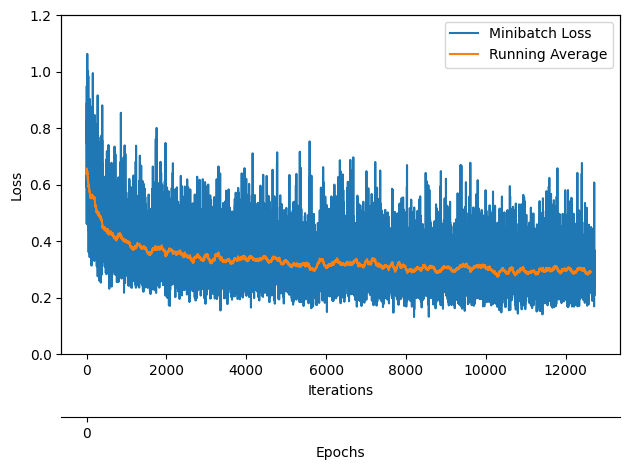

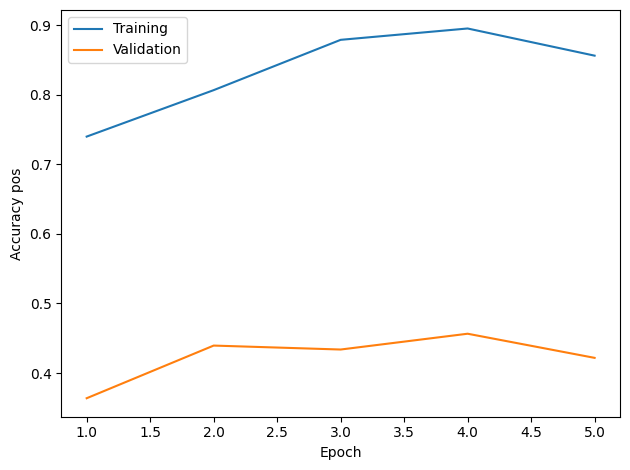

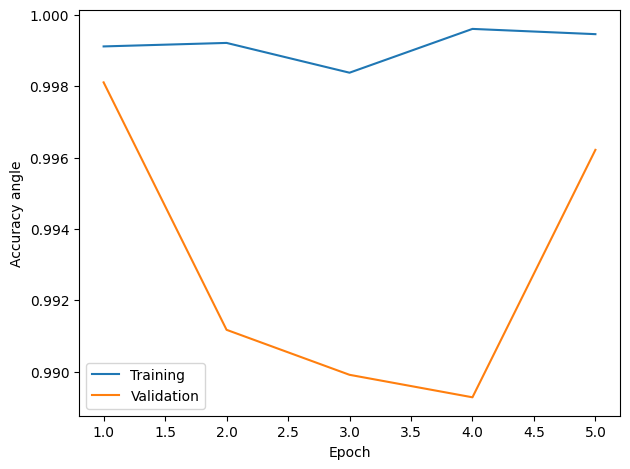

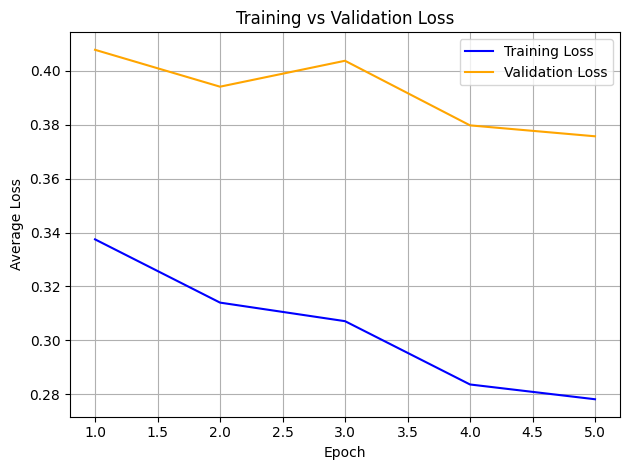

Average inference time: 6.69 ms
ATE mean: 81.250 m, median: 71.693 m
RPE mean: 1.326 m, median: 1.041 m
ATE quantiles (10,25,50,75,90): [ 25.33689091  50.52840024  71.69295671 129.55277083 139.28986521]
[26.7849, 46.3443, 53.0767, 59.1363, 71.9201, 96.6365, 134.5773, 141.9049, 130.787]


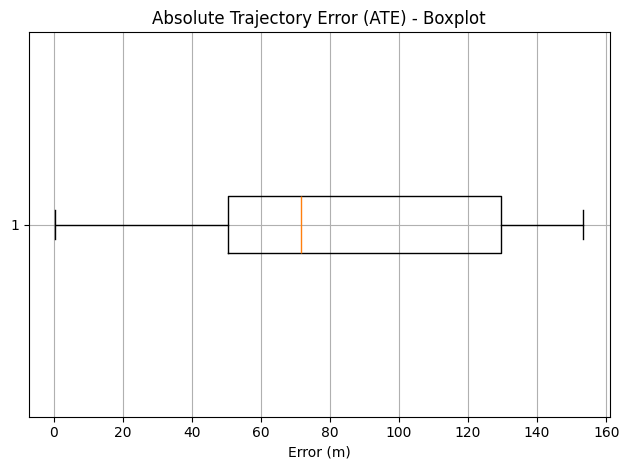

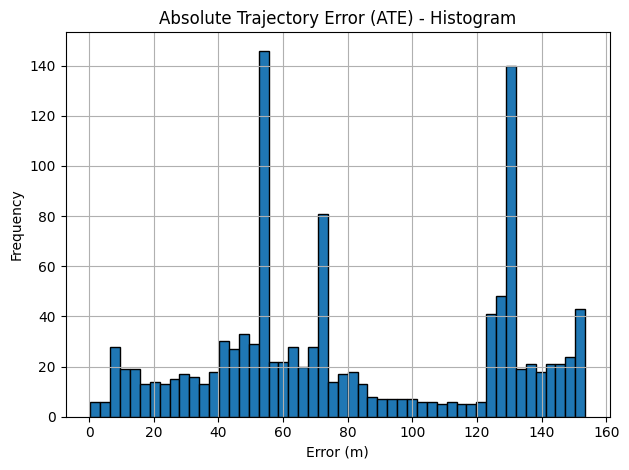

<ipython-input-17-22e18460e577>:133: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([angle_errors[:, i] for i in range(3)], labels=['Yaw', 'Pitch', 'Roll'])


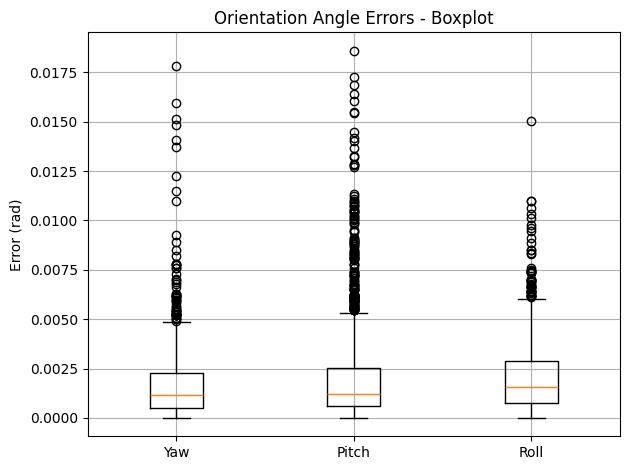

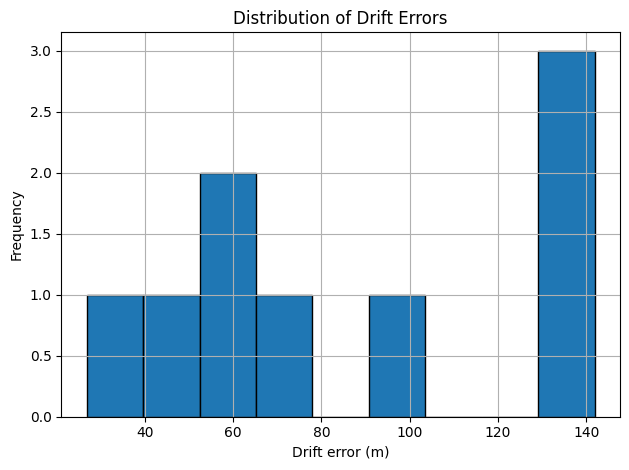

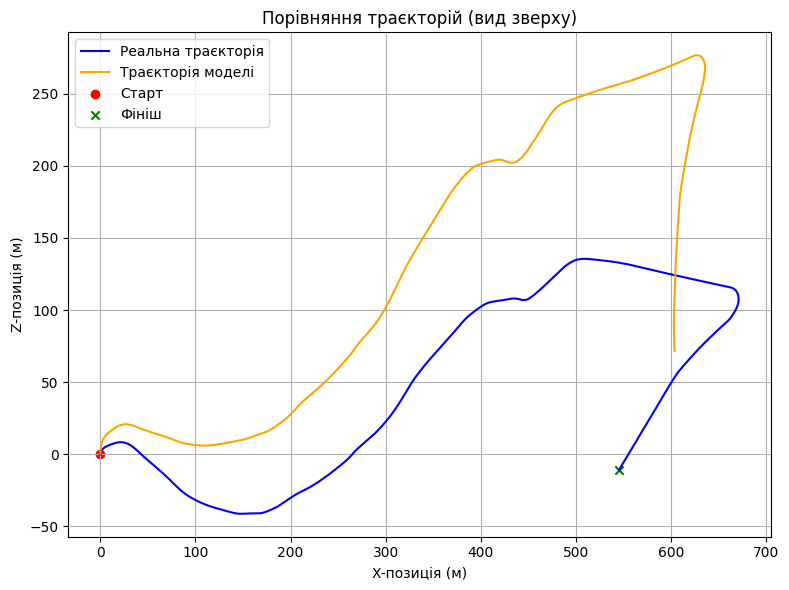

In [21]:
plot_training_loss(minibatch_loss_list, NUM_EPOCHS, iter_per_epoch = len(train_loader))
plt.show()
plot_accuracy(train_acc_pos, val_acc_pos, results_dir=None, type1 = "pos")
plt.show()
plot_accuracy(train_acc_angle, val_acc_angle, results_dir=None, type1 = "angle")
plt.show()
plot_epoch_losses(train_loss_list, valid_loss_list, results_dir=None)
plt.show()

pred, avg_time_per_pair,ate_errors, ate_mean, ate_median, ate_quantiles,rpe_errors,rpe_mean, rpe_median, angle_errors, drift = get_predicted_coordinates(model, test_loader, DEVICE)
print(f"Average inference time: {avg_time_per_pair:.2f} ms")
print(f"ATE mean: {ate_mean:.3f} m, median: {ate_median:.3f} m")
print(f"RPE mean: {rpe_mean:.3f} m, median: {rpe_median:.3f} m")
print(f"ATE quantiles (10,25,50,75,90): {ate_quantiles}")
rounded_data = [round(float(x), 4) for x in drift]
print(rounded_data)

true = get_true_coordinates()
# true1 = [true[:,3],true[:,7],true[:,11]]
# drift = compute_drift_over_distance(pred,true1)

plot_error_distributions(ate_errors, angle_errors,drift)
plot_predicted_vs_true_trajectory(pred, true)